In [2]:
# #unzip data set to folders
# import zipfile
# Data = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
# Data.extractall()
# Data.close()



In [2]:
# #unzip data set to folders
# import zipfile
# premodel = zipfile.ZipFile('resnet50.zip', 'r')
# premodel.extractall()
# premodel.close()


In [3]:
import sys
sys.path
sys.executable

'/opt/conda/bin/python'

In [4]:
import tensorflow as tf

In [5]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix

Using TensorFlow backend.


In [6]:
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline

In [7]:
device = 'cuda' if tf.test.is_gpu_available() else 'cpu' 
print(device)

cuda


In [8]:
# Define path to the data directory
data_dir = Path('./chest_xray/chest_xray')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [9]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray/chest_xray/train/PNEUMONIA/person40...,1
1,chest_xray/chest_xray/train/PNEUMONIA/person46...,1
2,chest_xray/chest_xray/train/PNEUMONIA/person10...,1
3,chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-...,0
4,chest_xray/chest_xray/train/PNEUMONIA/person15...,1


1    3875
0    1341
Name: label, dtype: int64


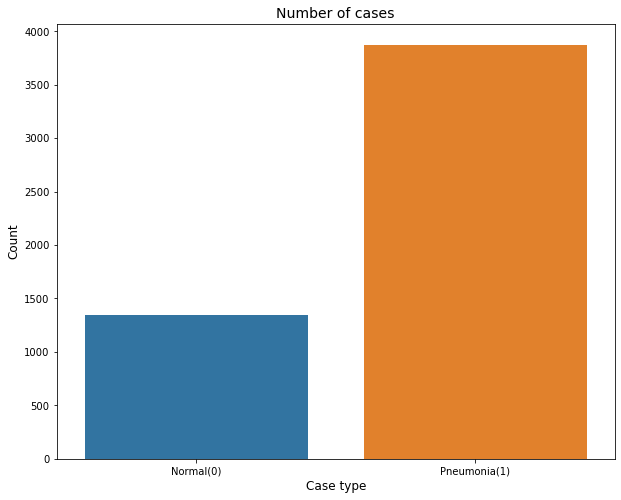

In [10]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

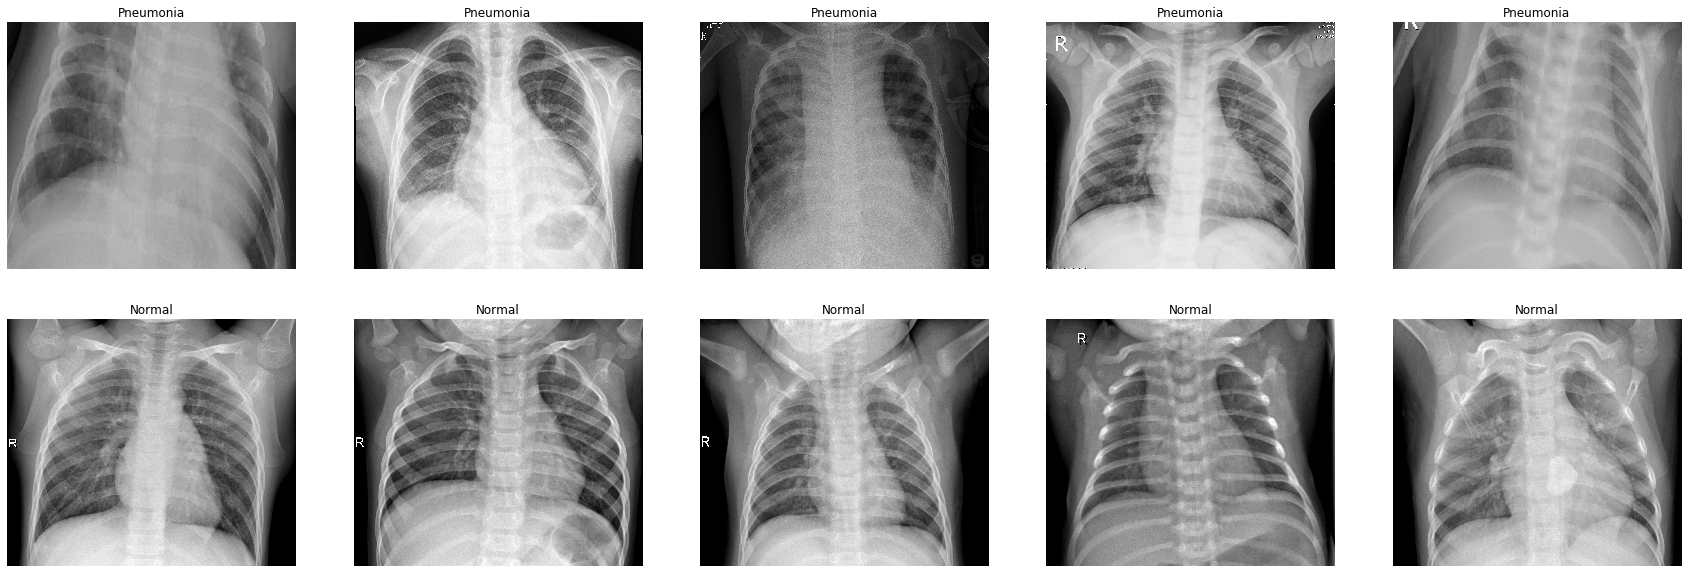

In [11]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [12]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    # Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


In [13]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [14]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
                            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
                            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [15]:
from keras.layers import GlobalAveragePooling2D
from keras import applications

In [21]:
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)

In [22]:
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
# # # # Load the model weights
# model.load_weights('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [24]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [27]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [28]:
batch_size = 16
nb_epochs = 20

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [29]:
# # Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/20
326/326 [==============================] - 70s 214ms/step - loss: 0.1483 - accuracy: 0.9208 - val_loss: 0.9326 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 54s 167ms/step - loss: 0.1263 - accuracy: 0.9523 - val_loss: 1.2059 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - 55s 169ms/step - loss: 0.1131 - accuracy: 0.9557 - val_loss: 0.5275 - val_accuracy: 0.7500
Epoch 4/20
326/326 [==============================] - 54s 164ms/step - loss: 0.1085 - accuracy: 0.9615 - val_loss: 0.9361 - val_accuracy: 0.5000
Epoch 5/20
326/326 [==============================] - 52s 158ms/step - loss: 0.1064 - accuracy: 0.9624 - val_loss: 0.2570 - val_accuracy: 0.8750
Epoch 6/20
326/326 [==============================] - 52s 160ms/step - loss: 0.1102 - accuracy: 0.9630 - val_loss: 0.1258 - val_accuracy: 0.9375
Epoch 7/20
326/326 [===============

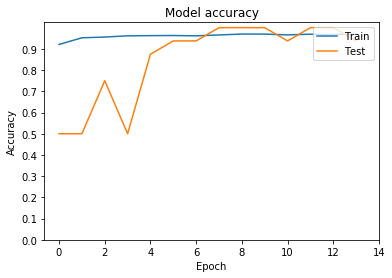

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

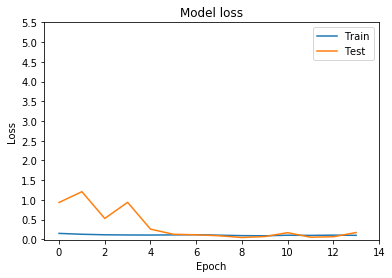

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 16, 2))
plt.yticks(np.arange(0, 6, 0.5))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [32]:
# import h5py
# hf2 = h5py.File('model_preResNet.h5', 'w')
# hf2.close()

In [33]:
# model.save_weights('model_preResNet.h5')

In [35]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)


Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [36]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 2s 3ms/step
Loss on test set:  0.9029696027581127
Accuracy on test set:  0.7227563858032227


In [37]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [38]:
cm  = confusion_matrix(orig_test_labels, preds)
cm

array([[ 61, 173],
       [  0, 390]])

<Figure size 432x288 with 0 Axes>

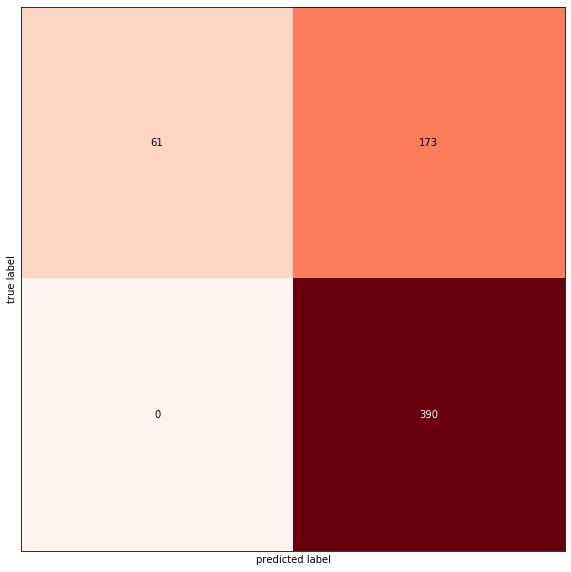

In [39]:
# Get the confusion matrix
plt.figure()
plot_confusion_matrix(cm,hide_ticks=True,cmap=plt.cm.Reds,figsize=(10,10))
# plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
# plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [40]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.69
